In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             f1_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix)
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from codecarbon import track_emissions

In [8]:
# Configurações iniciais
TASK = "Ischaemia"  # "Infection" ou "Ischaemia"
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 100
MODEL_NAME = "resnet50"  # "efficientnet" ou "resnet50"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# 1. Pré-processamento de Imagens
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
root_dir = "../data/ischaemia"


# 2. Dataset Customizado
class DFUDataset(Dataset):
    def __init__(self, root_dir, task=TASK, transform=None):
        self.root_dir = root_dir
        self.task = task

        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.identifiers = []  # Novo campo para identificadores únicos

        # Validate that root_dir is a valid path
        if not isinstance(root_dir, str):
            raise TypeError(f"Expected root_dir to be a string, but got {type(root_dir).__name__}")

        print("TASK: " + TASK)

        positive_dir = os.path.join(root_dir, "Aug-Positive")
        negative_dir = os.path.join(root_dir, "Aug-Negative")


        # Carregar imagens positivas
        for img_name in os.listdir(positive_dir):
            self.image_paths.append(os.path.join(positive_dir, img_name))
            self.labels.append(1)
            # Extrair identificador único (ex: "imagem" de "imagem_1X_M.jpg")
            identifier = img_name.split('_')[0]
            self.identifiers.append(identifier)

        # Carregar imagens negativas
        for img_name in os.listdir(negative_dir):
            self.image_paths.append(os.path.join(negative_dir, img_name))
            self.labels.append(0)
            identifier = img_name.split('_')[0]
            self.identifiers.append(identifier)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [28]:
# 3. Modelo com Regularização
def create_model():
    if MODEL_NAME == "resnet50":
        weights = ResNet50_Weights.IMAGENET1K_V1  # Ou ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 1)
        )
    elif MODEL_NAME == "efficientnet":
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1  # Ou EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, 1)
        )
    return model.to(DEVICE)

In [29]:
# 6. Cálculo de Métricas
def calculate_metrics(true, preds):
    preds_class = (preds > 0.5).astype(int)
    return {
        'auc': roc_auc_score(true, preds),
        'pr_auc': average_precision_score(true, preds),
        'f1': f1_score(true, preds_class),
        'accuracy': accuracy_score(true, preds_class),
        'precision': precision_score(true, preds_class),
        'recall': recall_score(true, preds_class),
        'confusion_matrix': confusion_matrix(true, preds_class)
    }

In [31]:
# 5. Função de Avaliação
@track_emissions()
def evaluate_model(model, loader, criterion):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            losses.append(loss.item())
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    metrics = calculate_metrics(np.array(all_labels), np.array(all_preds))
    return np.mean(losses), metrics

In [32]:
# 4. Função de Treinamento com Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, fold):
    best_loss = float('inf')
    patience_counter = 0
    patience = 3

    history = {
        'train_loss': [],
        'val_loss': [],
        'auc': [],
        'f1': []
    }

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Validação
        val_loss, val_metrics = evaluate_model(model, val_loader, criterion)
        epoch_loss = running_loss / len(train_loader.dataset)

        # Registrar métricas
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['auc'].append(val_metrics['auc'])
        history['f1'].append(val_metrics['f1'])

        print(f'Fold {fold}, Epoch {epoch+1}/{EPOCHS}')
        print(f'Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'Val AUC: {val_metrics["auc"]:.4f}, F1: {val_metrics["f1"]:.4f}')

        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fold{fold}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    return history

In [33]:
# 7. Grad-CAM
def generate_grad_cam(model, img_tensor, target_layer):
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0))
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img_tensor.permute(1,2,0).cpu().numpy(), grayscale_cam, use_rgb=True)
    return visualization

In [34]:
def plot_training_histories(histories):
    plt.figure(figsize=(15, 10))

    # Cores para diferentes folds
    colors = ['b', 'g', 'r', 'c', 'm']

    # Plot Loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['train_loss'])+1)
        plt.plot(epochs, history['train_loss'], linestyle='--', color=colors[i], label=f'Fold {i+1} Train')
        plt.plot(epochs, history['val_loss'], linestyle='-', color=colors[i], label=f'Fold {i+1} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot AUC
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['auc'])+1)
        plt.plot(epochs, history['auc'], color=colors[i], label=f'Fold {i+1}')
    plt.title('Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot F1-Score
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['f1'])+1)
        plt.plot(epochs, history['f1'], color=colors[i], label=f'Fold {i+1}')
    plt.title('Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig('training_histories.png')
    plt.show()

In [35]:
# 8. Validação Cruzada
@track_emissions()
def cross_validation():

    dataset = DFUDataset("../data/ischaemia", transform=transform)
    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)  # Alterado para StratifiedGroupKFold

    all_metrics = []
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(
        X=np.zeros(len(dataset.labels)),  # Dummy data
        y=dataset.labels,
        groups=dataset.identifiers  # Grupos dos identificadores
    )):
        print(f'\nFold {fold+1}/5')

        # Split adicional: 80% treino, 20% teste interno
        train_idx, test_idx = train_test_split(
            train_idx,
            test_size=0.2,
            stratify=np.array(dataset.labels)[train_idx],
            random_state=42
        )

        # Split datasets
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
        test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_subsampler)
        val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_subsampler)

        # Inicialização
        model = create_model()
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)  # L2 regularization

        history = train_model(model, train_loader, val_loader, criterion, optimizer, fold+1)
        fold_histories.append(history)

        plot_training_histories(fold_histories)

        # Avaliação no conjunto de teste interno
        model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
        _, test_metrics = evaluate_model(model, test_loader, criterion)

        # Carregar melhor modelo e avaliar
        model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
        _, metrics = evaluate_model(model, val_loader, criterion)

         # Adicione as métricas de teste
        all_metrics.append({
            'fold': fold+1,
            'val_metrics': metrics,
            'test_metrics': test_metrics
        })

    pd.DataFrame(fold_histories).to_csv('results/train_08/training_history.csv', index=False)


    # Processar all_metrics para formato tabular
    metrics_rows = []
    for m in all_metrics:
        row = {
            'fold': m['fold'],
            **{f'val_{k}': v for k, v in m['val_metrics'].items()},
            **{f'test_{k}': v for k, v in m['test_metrics'].items()}
        }
        metrics_rows.append(row)

    pd.DataFrame(metrics_rows).to_csv('results/train_08/fold_metrics.csv', index=False)

    # Relatório Final
    print("\nResultados da Validação Cruzada:")

    # Para métricas de validação
    print("\n--- Métricas de Validação ---")
    for key in all_metrics[0]['val_metrics']:
        if key != 'confusion_matrix':
            mean_val = np.mean([m['val_metrics'][key] for m in all_metrics])
            std_val = np.std([m['val_metrics'][key] for m in all_metrics])
            print(f'Val_{key.upper()}: {mean_val:.4f} ± {std_val:.4f}')

    # Para métricas de teste interno
    print("\n--- Métricas de Teste Interno ---")
    for key in all_metrics[0]['test_metrics']:
        if key != 'confusion_matrix':
            mean_test = np.mean([m['test_metrics'][key] for m in all_metrics])
            std_test = np.std([m['test_metrics'][key] for m in all_metrics])
            print(f'Test_{key.upper()}: {mean_test:.4f} ± {std_test:.4f}')

    return fold_histories, all_metrics

[codecarbon WARNING @ 18:50:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 18:50:11] [setup] RAM Tracking...
[codecarbon INFO @ 18:50:11] [setup] CPU Tracking...
[codecarbon WARNING @ 18:50:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 18:50:12] CPU Model on constant consumption mode: AMD Ryzen 5 7535HS with Radeon Graphics
[codecarbon WARNING @ 18:50:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:50:12] [setup] GPU Tracking...
[codecarbon INFO @ 18:50:12] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:50:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 18:50:12] >>> Tracker's me

TASK: Ischaemia

Fold 1/5
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\livma/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 52.2MB/s]
[codecarbon INFO @ 18:50:30] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 18:50:30] Delta energy consumed for CPU with constant : 0.001356 kWh, power : 324.0 W
[codecarbon INFO @ 18:50:31] Energy consumed for All CPU : 0.001356 kWh
[codecarbon INFO @ 18:50:31] Energy consumed for all GPUs : 0.000022 kWh. Total GPU Power : 5.283622802056144 W
[codecarbon INFO @ 18:50:31] 0.001420 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:50:46] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 18:50:46] Delta energy consumed for CPU with constant : 0.001361 kWh, power : 324.0 W
[codecarbon INFO @ 18:50:46] Energy consumed for All CPU : 0.002717 kWh
[codecarbon INFO @ 18:50:46] Energy consumed for all GPUs : 0.000045 kWh. Total GPU Power : 5.3746864426794385 W
[codecarbon INFO @ 18:50:46] 0.002845 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:0

Fold 1, Epoch 1/100
Train Loss: 0.2280 | Val Loss: 0.2290
Val AUC: 0.9721, F1: 0.9088


[codecarbon INFO @ 20:04:01] Energy consumed for RAM : 0.012132 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:04:02] Delta energy consumed for CPU with constant : 0.001364 kWh, power : 324.0 W
[codecarbon INFO @ 20:04:02] Energy consumed for All CPU : 0.397283 kWh
[codecarbon INFO @ 20:04:02] Energy consumed for all GPUs : 0.006918 kWh. Total GPU Power : 5.076193011820181 W
[codecarbon INFO @ 20:04:02] 0.416333 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:04:17] Energy consumed for RAM : 0.012173 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:04:17] Delta energy consumed for CPU with constant : 0.001335 kWh, power : 324.0 W
[codecarbon INFO @ 20:04:17] Energy consumed for All CPU : 0.398618 kWh
[codecarbon INFO @ 20:04:17] Energy consumed for all GPUs : 0.006940 kWh. Total GPU Power : 5.388814936127084 W
[codecarbon INFO @ 20:04:17] 0.417732 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:04:32] Energy consumed for RAM : 0.012214 kWh. RAM Power :

Fold 1, Epoch 2/100
Train Loss: 0.0866 | Val Loss: 0.2057
Val AUC: 0.9746, F1: 0.9040


[codecarbon INFO @ 21:09:25] Energy consumed for RAM : 0.022891 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:09:25] Delta energy consumed for CPU with constant : 0.001353 kWh, power : 324.0 W
[codecarbon INFO @ 21:09:25] Energy consumed for All CPU : 0.749521 kWh
[codecarbon INFO @ 21:09:25] Energy consumed for all GPUs : 0.012836 kWh. Total GPU Power : 5.269783660598283 W
[codecarbon INFO @ 21:09:25] 0.785248 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:09:40] Energy consumed for RAM : 0.022932 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:09:40] Delta energy consumed for CPU with constant : 0.001353 kWh, power : 324.0 W
[codecarbon INFO @ 21:09:40] Energy consumed for All CPU : 0.750873 kWh
[codecarbon INFO @ 21:09:40] Energy consumed for all GPUs : 0.012857 kWh. Total GPU Power : 5.114308505729874 W
[codecarbon INFO @ 21:09:40] 0.786663 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:09:55] Energy consumed for RAM : 0.022974 kWh. RAM Power :

Fold 1, Epoch 3/100
Train Loss: 0.0370 | Val Loss: 0.1980
Val AUC: 0.9774, F1: 0.9091


[codecarbon INFO @ 22:05:45] Energy consumed for RAM : 0.032175 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:05:45] Delta energy consumed for CPU with constant : 0.001355 kWh, power : 324.0 W
[codecarbon INFO @ 22:05:45] Energy consumed for All CPU : 1.052933 kWh
[codecarbon INFO @ 22:05:45] Energy consumed for all GPUs : 0.017929 kWh. Total GPU Power : 5.324133751250252 W
[codecarbon INFO @ 22:05:45] 1.103037 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:06:00] Energy consumed for RAM : 0.032216 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:06:00] Delta energy consumed for CPU with constant : 0.001350 kWh, power : 324.0 W
[codecarbon INFO @ 22:06:00] Energy consumed for All CPU : 1.054283 kWh
[codecarbon INFO @ 22:06:00] Energy consumed for all GPUs : 0.017951 kWh. Total GPU Power : 5.323964164321486 W
[codecarbon INFO @ 22:06:00] 1.104451 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:06:15] Energy consumed for RAM : 0.032258 kWh. RAM Power :

Fold 1, Epoch 4/100
Train Loss: 0.0188 | Val Loss: 0.2492
Val AUC: 0.9705, F1: 0.8902


[codecarbon INFO @ 22:59:19] Energy consumed for RAM : 0.041004 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:59:19] Delta energy consumed for CPU with constant : 0.001359 kWh, power : 324.0 W
[codecarbon INFO @ 22:59:19] Energy consumed for All CPU : 1.341584 kWh
[codecarbon INFO @ 22:59:19] Energy consumed for all GPUs : 0.022722 kWh. Total GPU Power : 5.373127401392848 W
[codecarbon INFO @ 22:59:19] 1.405309 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:59:34] Energy consumed for RAM : 0.041045 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:59:34] Delta energy consumed for CPU with constant : 0.001348 kWh, power : 324.0 W
[codecarbon INFO @ 22:59:34] Energy consumed for All CPU : 1.342932 kWh
[codecarbon INFO @ 22:59:34] Energy consumed for all GPUs : 0.022744 kWh. Total GPU Power : 5.285870984384236 W
[codecarbon INFO @ 22:59:34] 1.406721 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:59:49] Energy consumed for RAM : 0.041087 kWh. RAM Power :

Fold 1, Epoch 5/100
Train Loss: 0.0102 | Val Loss: 0.2705
Val AUC: 0.9685, F1: 0.8963


[codecarbon INFO @ 23:49:52] Energy consumed for RAM : 0.049342 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:49:52] Delta energy consumed for CPU with constant : 0.001357 kWh, power : 324.0 W
[codecarbon INFO @ 23:49:52] Energy consumed for All CPU : 1.613868 kWh
[codecarbon INFO @ 23:49:52] Energy consumed for all GPUs : 0.027233 kWh. Total GPU Power : 5.414467387065021 W
[codecarbon INFO @ 23:49:52] 1.690443 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:50:07] Energy consumed for RAM : 0.049384 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:50:07] Delta energy consumed for CPU with constant : 0.001351 kWh, power : 324.0 W
[codecarbon INFO @ 23:50:07] Energy consumed for All CPU : 1.615219 kWh
[codecarbon INFO @ 23:50:07] Energy consumed for all GPUs : 0.027255 kWh. Total GPU Power : 5.395621026973389 W
[codecarbon INFO @ 23:50:07] 1.691858 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:50:22] Energy consumed for RAM : 0.049425 kWh. RAM Power :

Fold 1, Epoch 6/100
Train Loss: 0.0119 | Val Loss: 0.3289
Val AUC: 0.9689, F1: 0.8577
Early stopping at epoch 6


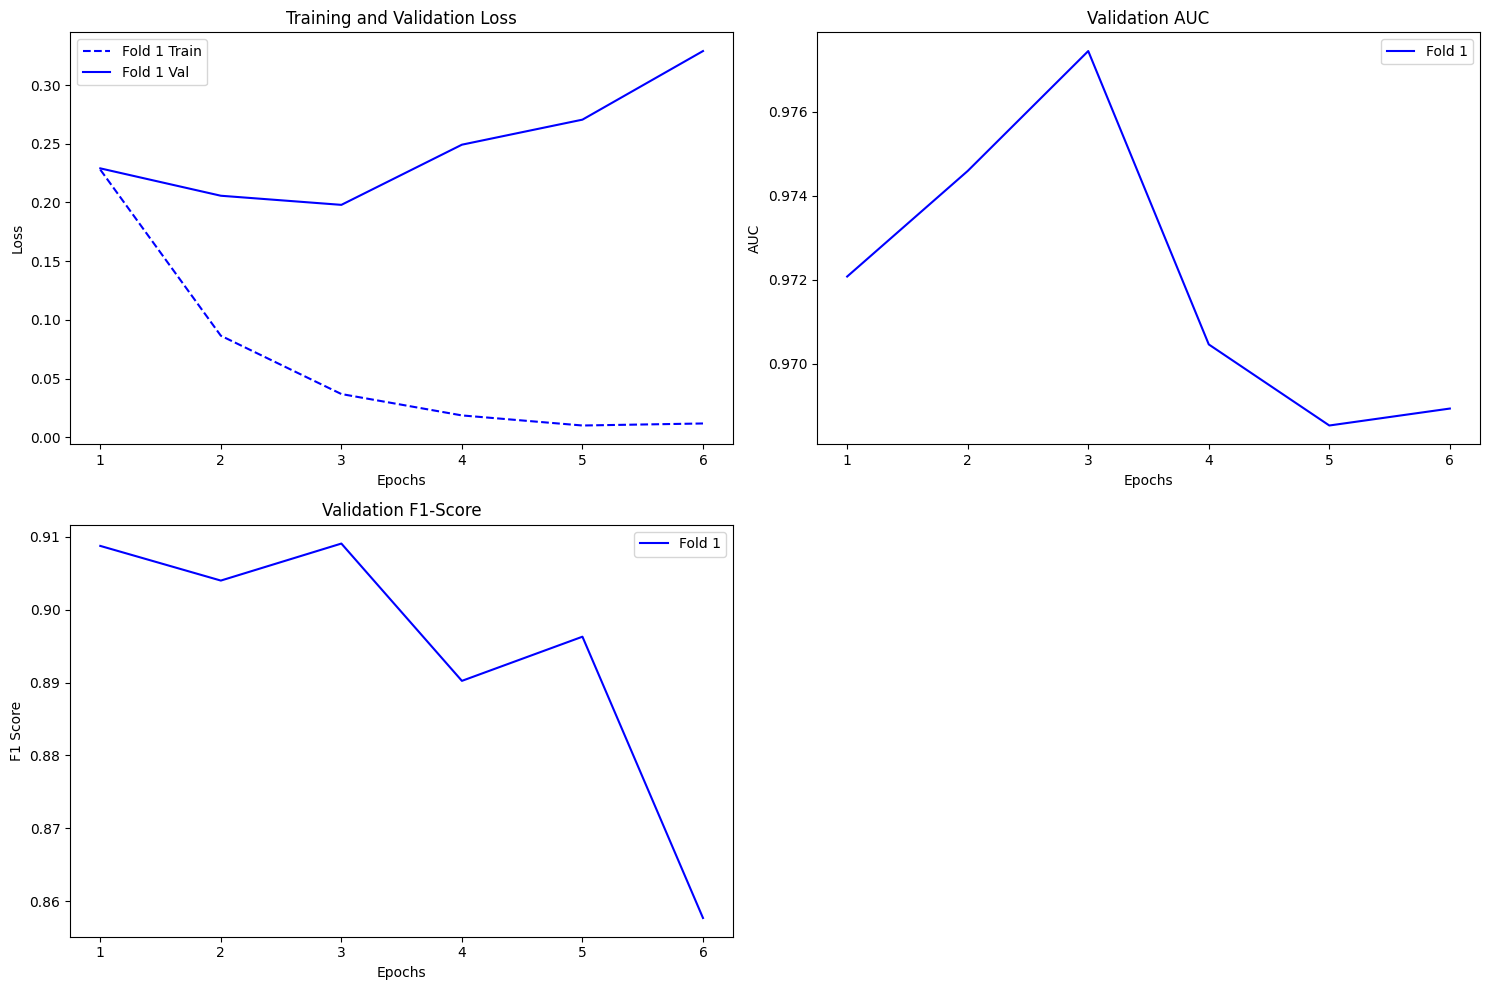

[codecarbon WARNING @ 00:39:48] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:39:48] [setup] RAM Tracking...
[codecarbon INFO @ 00:39:48] [setup] CPU Tracking...
[codecarbon WARNING @ 00:39:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 00:39:50] CPU Model on constant consumption mode: AMD Ryzen 5 7535HS with Radeon Graphics
[codecarbon WARNING @ 00:39:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:39:50] [setup] GPU Tracking...
[codecarbon INFO @ 00:39:50] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:39:50] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 00:39:50] >>> Tracker's me


Fold 2/5


[codecarbon INFO @ 00:43:56] Energy consumed for RAM : 0.058270 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:43:56] Delta energy consumed for CPU with constant : 0.001363 kWh, power : 324.0 W
[codecarbon INFO @ 00:43:56] Energy consumed for All CPU : 1.905221 kWh
[codecarbon INFO @ 00:43:56] Energy consumed for all GPUs : 0.032229 kWh. Total GPU Power : 5.750577808853889 W
[codecarbon INFO @ 00:43:56] 1.995720 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:44:11] Energy consumed for RAM : 0.058311 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:44:11] Delta energy consumed for CPU with constant : 0.001343 kWh, power : 324.0 W
[codecarbon INFO @ 00:44:11] Energy consumed for All CPU : 1.906564 kWh
[codecarbon INFO @ 00:44:11] Energy consumed for all GPUs : 0.032252 kWh. Total GPU Power : 5.653749032096214 W
[codecarbon INFO @ 00:44:11] 1.997128 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:44:26] Energy consumed for RAM : 0.058352 kWh. RAM Power :

Fold 2, Epoch 1/100
Train Loss: 0.2218 | Val Loss: 0.2513
Val AUC: 0.9631, F1: 0.8917


[codecarbon INFO @ 01:07:42] Energy consumed for RAM : 0.062220 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 01:07:42] Delta energy consumed for CPU with constant : 0.001350 kWh, power : 324.0 W
[codecarbon INFO @ 01:07:42] Energy consumed for All CPU : 2.033424 kWh
[codecarbon INFO @ 01:07:42] Energy consumed for all GPUs : 0.034489 kWh. Total GPU Power : 5.874210274294155 W
[codecarbon INFO @ 01:07:42] 2.130133 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:07:57] Energy consumed for RAM : 0.062262 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 01:07:57] Delta energy consumed for CPU with constant : 0.001391 kWh, power : 324.0 W
[codecarbon INFO @ 01:07:57] Energy consumed for All CPU : 2.034815 kWh
[codecarbon INFO @ 01:07:57] Energy consumed for all GPUs : 0.034513 kWh. Total GPU Power : 5.695710820942465 W
[codecarbon INFO @ 01:07:57] 2.131590 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:08:12] Energy consumed for RAM : 0.062302 kWh. RAM Power :

Fold 2, Epoch 2/100
Train Loss: 0.0763 | Val Loss: 0.2814
Val AUC: 0.9607, F1: 0.8767


[codecarbon INFO @ 01:31:43] Energy consumed for RAM : 0.066210 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 01:31:43] Delta energy consumed for CPU with constant : 0.001349 kWh, power : 324.0 W
[codecarbon INFO @ 01:31:43] Energy consumed for All CPU : 2.162973 kWh
[codecarbon INFO @ 01:31:43] Energy consumed for all GPUs : 0.036797 kWh. Total GPU Power : 5.578493874846893 W
[codecarbon INFO @ 01:31:43] 2.265980 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:31:58] Energy consumed for RAM : 0.066252 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 01:31:58] Delta energy consumed for CPU with constant : 0.001358 kWh, power : 324.0 W
[codecarbon INFO @ 01:31:58] Energy consumed for All CPU : 2.164331 kWh
[codecarbon INFO @ 01:31:58] Energy consumed for all GPUs : 0.036821 kWh. Total GPU Power : 5.668842463912712 W
[codecarbon INFO @ 01:31:58] 2.267403 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:32:13] Energy consumed for RAM : 0.066293 kWh. RAM Power :

Fold 2, Epoch 3/100
Train Loss: 0.0320 | Val Loss: 0.3405
Val AUC: 0.9606, F1: 0.8647


[codecarbon INFO @ 01:55:44] Energy consumed for RAM : 0.070202 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 01:55:44] Delta energy consumed for CPU with constant : 0.001354 kWh, power : 324.0 W
[codecarbon INFO @ 01:55:44] Energy consumed for All CPU : 2.292539 kWh
[codecarbon INFO @ 01:55:44] Energy consumed for all GPUs : 0.039030 kWh. Total GPU Power : 5.542302700685848 W
[codecarbon INFO @ 01:55:44] 2.401771 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:55:59] Energy consumed for RAM : 0.070243 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 01:55:59] Delta energy consumed for CPU with constant : 0.001352 kWh, power : 324.0 W
[codecarbon INFO @ 01:55:59] Energy consumed for All CPU : 2.293890 kWh
[codecarbon INFO @ 01:55:59] Energy consumed for all GPUs : 0.039053 kWh. Total GPU Power : 5.50825720852125 W
[codecarbon INFO @ 01:55:59] 2.403187 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:56:14] Energy consumed for RAM : 0.070285 kWh. RAM Power : 

Fold 2, Epoch 4/100
Train Loss: 0.0135 | Val Loss: 0.3026
Val AUC: 0.9658, F1: 0.8857
Early stopping at epoch 4


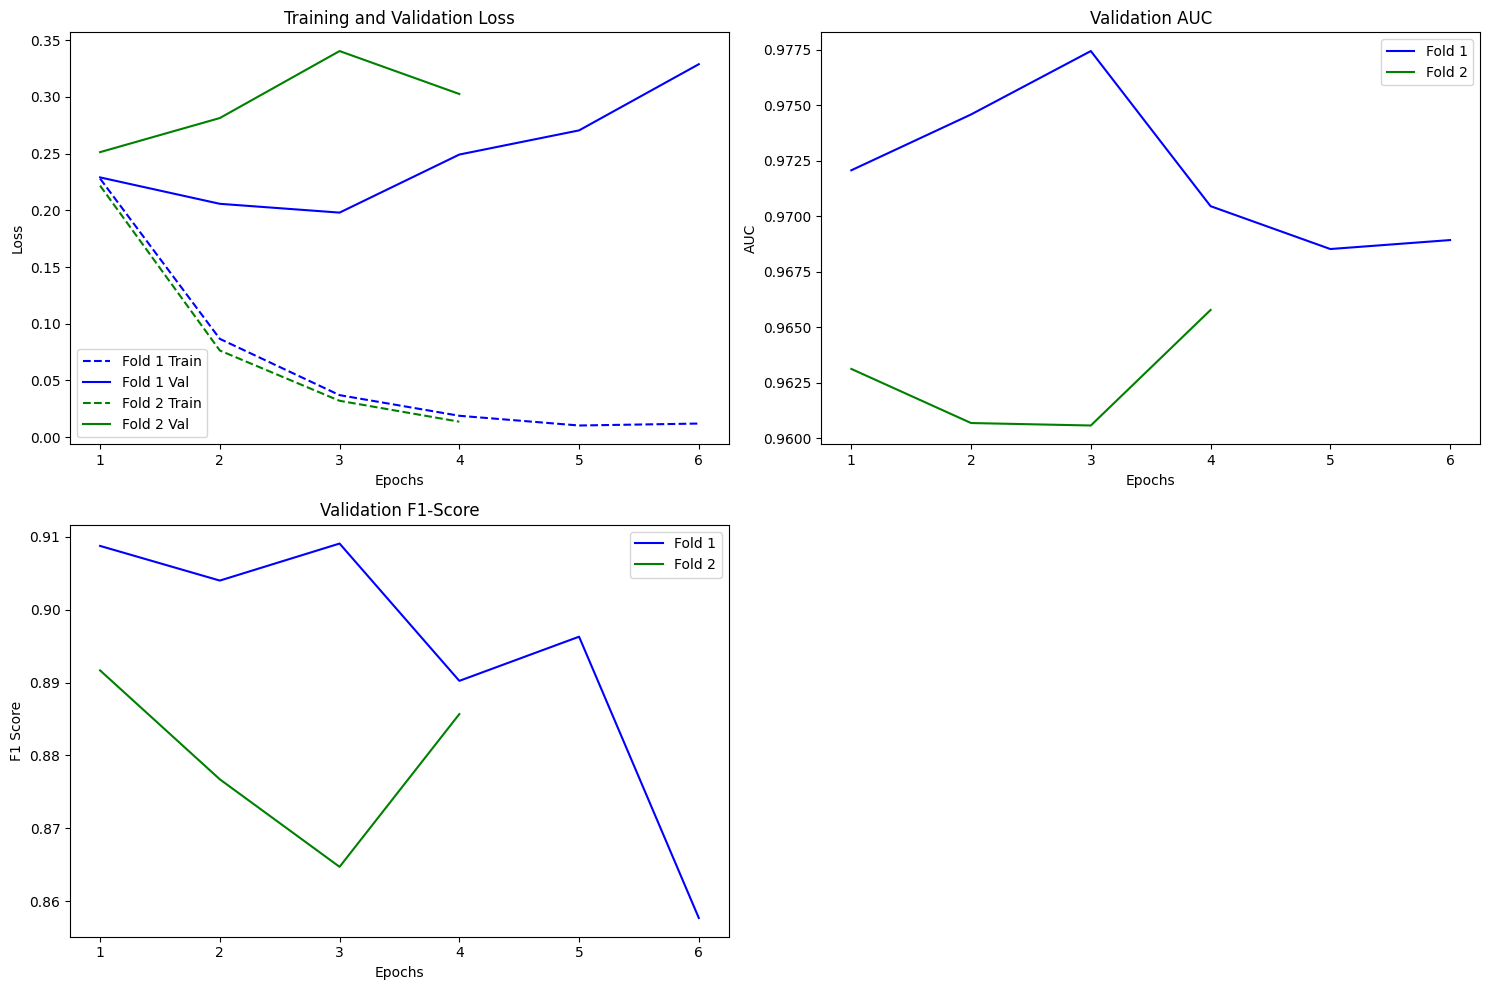

[codecarbon WARNING @ 02:19:05] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 02:19:05] [setup] RAM Tracking...
[codecarbon INFO @ 02:19:05] [setup] CPU Tracking...
[codecarbon WARNING @ 02:19:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 02:19:07] CPU Model on constant consumption mode: AMD Ryzen 5 7535HS with Radeon Graphics
[codecarbon WARNING @ 02:19:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 02:19:07] [setup] GPU Tracking...
[codecarbon INFO @ 02:19:07] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:19:07] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 02:19:07] >>> Tracker's me


Fold 3/5


[codecarbon INFO @ 02:23:00] Energy consumed for RAM : 0.074736 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:23:00] Delta energy consumed for CPU with constant : 0.001358 kWh, power : 324.0 W
[codecarbon INFO @ 02:23:00] Energy consumed for All CPU : 2.439655 kWh
[codecarbon INFO @ 02:23:00] Energy consumed for all GPUs : 0.041617 kWh. Total GPU Power : 5.613033689309649 W
[codecarbon INFO @ 02:23:00] 2.556008 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:23:00] 0.009269 g.CO2eq/s mean an estimation of 292.32245349246523 kg.CO2eq/year
[codecarbon INFO @ 02:23:15] Energy consumed for RAM : 0.074777 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:23:15] Delta energy consumed for CPU with constant : 0.001347 kWh, power : 324.0 W
[codecarbon INFO @ 02:23:15] Energy consumed for All CPU : 2.441002 kWh
[codecarbon INFO @ 02:23:15] Energy consumed for all GPUs : 0.041641 kWh. Total GPU Power : 5.710121747021745 W
[codecarbon INFO @ 02:23:15] 2.557420 kWh of electricity use

Fold 3, Epoch 1/100
Train Loss: 0.2247 | Val Loss: 0.2669
Val AUC: 0.9606, F1: 0.8864


[codecarbon INFO @ 02:47:01] Energy consumed for RAM : 0.078728 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:47:01] Delta energy consumed for CPU with constant : 0.001361 kWh, power : 324.0 W
[codecarbon INFO @ 02:47:01] Energy consumed for All CPU : 2.569221 kWh
[codecarbon INFO @ 02:47:01] Energy consumed for all GPUs : 0.043887 kWh. Total GPU Power : 5.733005556528553 W
[codecarbon INFO @ 02:47:01] 2.691836 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:47:01] 0.009272 g.CO2eq/s mean an estimation of 292.3973358631095 kg.CO2eq/year
[codecarbon INFO @ 02:47:16] Energy consumed for RAM : 0.078769 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:47:16] Delta energy consumed for CPU with constant : 0.001346 kWh, power : 324.0 W
[codecarbon INFO @ 02:47:16] Energy consumed for All CPU : 2.570567 kWh
[codecarbon INFO @ 02:47:16] Energy consumed for all GPUs : 0.043911 kWh. Total GPU Power : 5.673986398440087 W
[codecarbon INFO @ 02:47:16] 2.693247 kWh of electricity used

Fold 3, Epoch 2/100
Train Loss: 0.0834 | Val Loss: 0.2987
Val AUC: 0.9595, F1: 0.8873


[codecarbon INFO @ 03:11:02] Energy consumed for RAM : 0.082719 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 03:11:02] Delta energy consumed for CPU with constant : 0.001354 kWh, power : 324.0 W
[codecarbon INFO @ 03:11:02] Energy consumed for All CPU : 2.698772 kWh
[codecarbon INFO @ 03:11:02] Energy consumed for all GPUs : 0.046113 kWh. Total GPU Power : 5.335312241191012 W
[codecarbon INFO @ 03:11:02] 2.827604 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:11:02] 0.009264 g.CO2eq/s mean an estimation of 292.14973005735146 kg.CO2eq/year
[codecarbon INFO @ 03:11:17] Energy consumed for RAM : 0.082761 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 03:11:17] Delta energy consumed for CPU with constant : 0.001352 kWh, power : 324.0 W
[codecarbon INFO @ 03:11:17] Energy consumed for All CPU : 2.700124 kWh
[codecarbon INFO @ 03:11:17] Energy consumed for all GPUs : 0.046136 kWh. Total GPU Power : 5.438634992054874 W
[codecarbon INFO @ 03:11:17] 2.829020 kWh of electricity use

Fold 3, Epoch 3/100
Train Loss: 0.0353 | Val Loss: 0.3179
Val AUC: 0.9575, F1: 0.8828


[codecarbon INFO @ 03:34:48] Energy consumed for RAM : 0.086669 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 03:34:48] Delta energy consumed for CPU with constant : 0.001358 kWh, power : 324.0 W
[codecarbon INFO @ 03:34:48] Energy consumed for All CPU : 2.826977 kWh
[codecarbon INFO @ 03:34:48] Energy consumed for all GPUs : 0.048323 kWh. Total GPU Power : 5.4369198409499875 W
[codecarbon INFO @ 03:34:48] 2.961969 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:35:03] Energy consumed for RAM : 0.086710 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 03:35:03] Delta energy consumed for CPU with constant : 0.001346 kWh, power : 324.0 W
[codecarbon INFO @ 03:35:03] Energy consumed for All CPU : 2.828324 kWh
[codecarbon INFO @ 03:35:03] Energy consumed for all GPUs : 0.048347 kWh. Total GPU Power : 5.634112164102603 W
[codecarbon INFO @ 03:35:03] 2.963380 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:35:03] 0.009267 g.CO2eq/s mean an estimation of 292.25336

Fold 3, Epoch 4/100
Train Loss: 0.0191 | Val Loss: 0.2942
Val AUC: 0.9575, F1: 0.8930
Early stopping at epoch 4


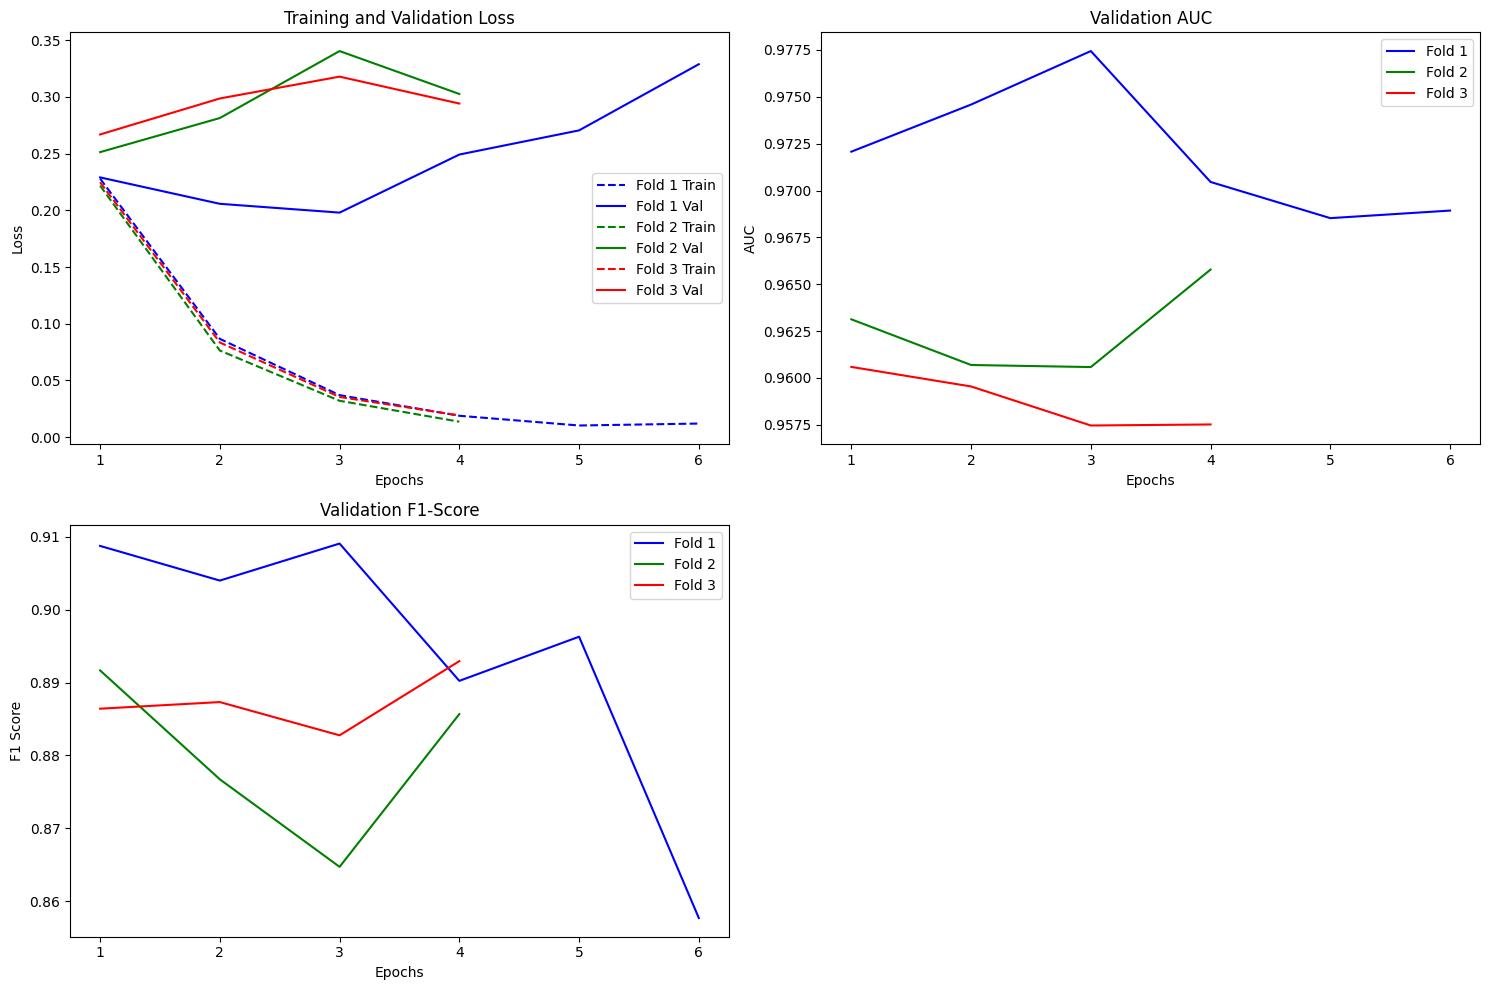

[codecarbon WARNING @ 03:58:51] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 03:58:51] [setup] RAM Tracking...
[codecarbon INFO @ 03:58:51] [setup] CPU Tracking...
[codecarbon WARNING @ 03:58:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 03:58:52] CPU Model on constant consumption mode: AMD Ryzen 5 7535HS with Radeon Graphics
[codecarbon WARNING @ 03:58:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 03:58:52] [setup] GPU Tracking...
[codecarbon INFO @ 03:58:52] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:58:52] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 03:58:52] >>> Tracker's me


Fold 4/5


[codecarbon INFO @ 04:02:49] Energy consumed for RAM : 0.091325 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 04:02:49] Delta energy consumed for CPU with constant : 0.001355 kWh, power : 324.0 W
[codecarbon INFO @ 04:02:49] Energy consumed for All CPU : 2.978120 kWh
[codecarbon INFO @ 04:02:49] Energy consumed for all GPUs : 0.050916 kWh. Total GPU Power : 5.5664846669107195 W
[codecarbon INFO @ 04:02:49] 3.120362 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:03:04] Energy consumed for RAM : 0.091367 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 04:03:04] Delta energy consumed for CPU with constant : 0.001351 kWh, power : 324.0 W
[codecarbon INFO @ 04:03:04] Energy consumed for All CPU : 2.979471 kWh
[codecarbon INFO @ 04:03:04] Energy consumed for all GPUs : 0.050939 kWh. Total GPU Power : 5.469813346385758 W
[codecarbon INFO @ 04:03:04] 3.121777 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:03:04] 0.009268 g.CO2eq/s mean an estimation of 292.27587

Fold 4, Epoch 1/100
Train Loss: 0.2324 | Val Loss: 0.2037
Val AUC: 0.9735, F1: 0.9380


[codecarbon INFO @ 04:36:05] Energy consumed for RAM : 0.096834 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 04:36:05] Delta energy consumed for CPU with constant : 0.001358 kWh, power : 324.0 W
[codecarbon INFO @ 04:36:05] Energy consumed for All CPU : 3.157519 kWh
[codecarbon INFO @ 04:36:05] Energy consumed for all GPUs : 0.053994 kWh. Total GPU Power : 5.457173993364306 W
[codecarbon INFO @ 04:36:05] 3.308347 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:36:20] Energy consumed for RAM : 0.096876 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 04:36:20] Delta energy consumed for CPU with constant : 0.001348 kWh, power : 324.0 W
[codecarbon INFO @ 04:36:20] Energy consumed for All CPU : 3.158867 kWh
[codecarbon INFO @ 04:36:20] Energy consumed for all GPUs : 0.054017 kWh. Total GPU Power : 5.441113326456206 W
[codecarbon INFO @ 04:36:20] 3.309760 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:36:35] Energy consumed for RAM : 0.096917 kWh. RAM Power :

Fold 4, Epoch 2/100
Train Loss: 0.0828 | Val Loss: 0.2119
Val AUC: 0.9719, F1: 0.9411


[codecarbon INFO @ 05:09:22] Energy consumed for RAM : 0.102345 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:09:22] Delta energy consumed for CPU with constant : 0.001355 kWh, power : 324.0 W
[codecarbon INFO @ 05:09:22] Energy consumed for All CPU : 3.336939 kWh
[codecarbon INFO @ 05:09:22] Energy consumed for all GPUs : 0.057068 kWh. Total GPU Power : 5.493392714700272 W
[codecarbon INFO @ 05:09:22] 3.496352 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:09:37] Energy consumed for RAM : 0.102387 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:09:37] Delta energy consumed for CPU with constant : 0.001352 kWh, power : 324.0 W
[codecarbon INFO @ 05:09:37] Energy consumed for All CPU : 3.338291 kWh
[codecarbon INFO @ 05:09:37] Energy consumed for all GPUs : 0.057091 kWh. Total GPU Power : 5.453701468116165 W
[codecarbon INFO @ 05:09:37] 3.497768 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:09:52] Energy consumed for RAM : 0.102428 kWh. RAM Power :

Fold 4, Epoch 3/100
Train Loss: 0.0339 | Val Loss: 0.2389
Val AUC: 0.9723, F1: 0.9397


[codecarbon INFO @ 05:46:39] Energy consumed for RAM : 0.108510 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:46:39] Delta energy consumed for CPU with constant : 0.001370 kWh, power : 324.0 W
[codecarbon INFO @ 05:46:39] Energy consumed for All CPU : 3.537910 kWh
[codecarbon INFO @ 05:46:39] Energy consumed for all GPUs : 0.060529 kWh. Total GPU Power : 5.454993562548328 W
[codecarbon INFO @ 05:46:39] 3.706949 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:46:54] Energy consumed for RAM : 0.108551 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 05:46:54] Delta energy consumed for CPU with constant : 0.001340 kWh, power : 324.0 W
[codecarbon INFO @ 05:46:54] Energy consumed for All CPU : 3.539251 kWh
[codecarbon INFO @ 05:46:54] Energy consumed for all GPUs : 0.060552 kWh. Total GPU Power : 5.6158976560334075 W
[codecarbon INFO @ 05:46:54] 3.708354 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:47:09] Energy consumed for RAM : 0.108592 kWh. RAM Power 

Fold 4, Epoch 4/100
Train Loss: 0.0165 | Val Loss: 0.2322
Val AUC: 0.9721, F1: 0.9424
Early stopping at epoch 4


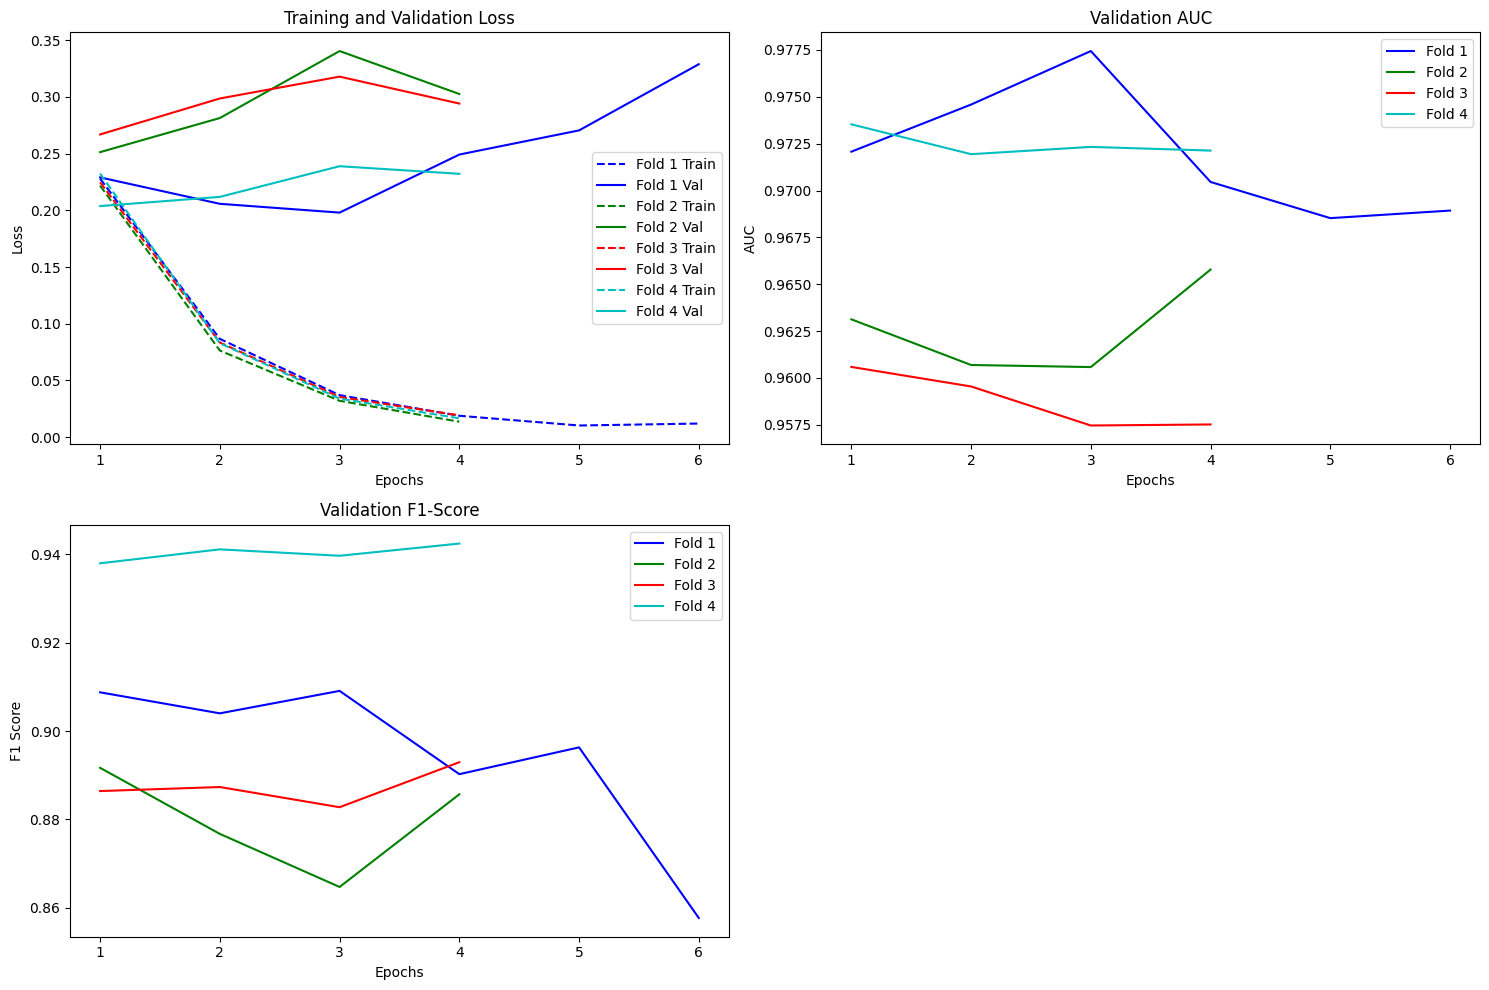

[codecarbon WARNING @ 06:20:36] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 06:20:36] [setup] RAM Tracking...
[codecarbon INFO @ 06:20:36] [setup] CPU Tracking...
[codecarbon WARNING @ 06:20:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 06:20:37] CPU Model on constant consumption mode: AMD Ryzen 5 7535HS with Radeon Graphics
[codecarbon WARNING @ 06:20:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 06:20:37] [setup] GPU Tracking...
[codecarbon INFO @ 06:20:37] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 06:20:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 06:20:37] >>> Tracker's me


Fold 5/5


[codecarbon INFO @ 06:24:25] Energy consumed for RAM : 0.114768 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 06:24:25] Delta energy consumed for CPU with constant : 0.001350 kWh, power : 324.0 W
[codecarbon INFO @ 06:24:25] Energy consumed for All CPU : 3.741604 kWh
[codecarbon INFO @ 06:24:25] Energy consumed for all GPUs : 0.064079 kWh. Total GPU Power : 5.7805171574530805 W
[codecarbon INFO @ 06:24:25] 3.920452 kWh of electricity used since the beginning.
[codecarbon INFO @ 06:24:40] Energy consumed for RAM : 0.114810 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 06:24:41] Delta energy consumed for CPU with constant : 0.001364 kWh, power : 324.0 W
[codecarbon INFO @ 06:24:41] Energy consumed for All CPU : 3.742969 kWh
[codecarbon INFO @ 06:24:41] Energy consumed for all GPUs : 0.064104 kWh. Total GPU Power : 5.75766602671039 W
[codecarbon INFO @ 06:24:41] 3.921882 kWh of electricity used since the beginning.
[codecarbon INFO @ 06:24:55] Energy consumed for RAM : 0.114852 kWh. RAM Power :

Fold 5, Epoch 1/100
Train Loss: 0.2345 | Val Loss: 0.2073
Val AUC: 0.9777, F1: 0.9225


[codecarbon INFO @ 06:48:41] Energy consumed for RAM : 0.118799 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 06:48:41] Delta energy consumed for CPU with constant : 0.001359 kWh, power : 324.0 W
[codecarbon INFO @ 06:48:41] Energy consumed for All CPU : 3.872507 kWh
[codecarbon INFO @ 06:48:41] Energy consumed for all GPUs : 0.066447 kWh. Total GPU Power : 5.7807843018951255 W
[codecarbon INFO @ 06:48:41] 4.057754 kWh of electricity used since the beginning.
[codecarbon INFO @ 06:48:56] Energy consumed for RAM : 0.118841 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 06:48:57] Delta energy consumed for CPU with constant : 0.001358 kWh, power : 324.0 W
[codecarbon INFO @ 06:48:57] Energy consumed for All CPU : 3.873865 kWh
[codecarbon INFO @ 06:48:57] Energy consumed for all GPUs : 0.066471 kWh. Total GPU Power : 5.709882107224223 W
[codecarbon INFO @ 06:48:57] 4.059177 kWh of electricity used since the beginning.
[codecarbon INFO @ 06:49:12] Energy consumed for RAM : 0.118882 kWh. RAM Power 

Fold 5, Epoch 2/100
Train Loss: 0.0848 | Val Loss: 0.1859
Val AUC: 0.9819, F1: 0.9263


[codecarbon INFO @ 07:14:13] Energy consumed for RAM : 0.123034 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 07:14:13] Delta energy consumed for CPU with constant : 0.001356 kWh, power : 324.0 W
[codecarbon INFO @ 07:14:13] Energy consumed for All CPU : 4.010124 kWh
[codecarbon INFO @ 07:14:13] Energy consumed for all GPUs : 0.068885 kWh. Total GPU Power : 5.795589343427368 W
[codecarbon INFO @ 07:14:13] 4.202043 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:14:28] Energy consumed for RAM : 0.123075 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 07:14:28] Delta energy consumed for CPU with constant : 0.001352 kWh, power : 324.0 W
[codecarbon INFO @ 07:14:28] Energy consumed for All CPU : 4.011477 kWh
[codecarbon INFO @ 07:14:28] Energy consumed for all GPUs : 0.068909 kWh. Total GPU Power : 5.646306690171916 W
[codecarbon INFO @ 07:14:28] 4.203460 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:14:43] Energy consumed for RAM : 0.123117 kWh. RAM Power :

CPU times: total: 2d 17h 40min 4s
Wall time: 12h 49min 25s


KeyboardInterrupt: 

In [36]:
%%time
# Executar
if __name__ == "__main__":
    fold_histories, all_metrics = cross_validation()

    # Exemplo Grad-CAM
    # model = create_model().eval()
    # sample_img, _ = dataset[0]
    # target_layer = model.layer4[-1] if MODEL_NAME == "resnet50" else model.features[-1]
    # cam_image = generate_grad_cam(model, sample_img.to(DEVICE), target_layer)
    #
    # plt.imshow(cam_image)
    # plt.title('Grad-CAM Visualization')
    # plt.axis('off')
    # plt.show()